In [1]:
import pandas as pd 

import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'pmdarima'

In [68]:
df = pd.read_csv('Crude oil.csv')

cols_to_interpolate = ['D3', 'D4', 'D5', 'D6']

for col in cols_to_interpolate:
    df[col] = df[col].interpolate(method='polynomial', order=2, limit_direction = 'both').bfill().ffill()

# Only forward fill
df['food inflation index (cpi)'] = df['food inflation index (cpi)'].interpolate(method='polynomial', order=2, limit_direction = 'forward').ffill()

# Drop NAs
df = df.dropna()

# DF
df

,Date,DJSI-US,food inflation index (cpi),D3,D4,D5,D6,Crude-Oil
18,3/1/2011,103.32,92.110000,1.200000,0.854260,0.531345,0.010102,113.34
19,3/3/2011,104.83,92.127173,1.200000,0.876076,0.507671,0.010250,114.42
20,3/4/2011,103.99,92.144182,1.200000,0.907353,0.482661,0.010273,115.71
21,3/7/2011,103.20,92.161027,1.200000,0.930000,0.470000,0.010000,116.58
22,3/8/2011,104.00,92.177709,1.200000,0.944016,0.469689,0.009432,112.32
...,...,...,...,...,...,...,...,...
2192,12/24/2019,249.38,99.680000,0.965763,0.415734,0.476455,0.071251,69.26
2193,12/26/2019,251.86,99.680000,0.929350,0.400979,0.481941,0.058335,69.26
2194,12/27/2019,253.88,99.680000,0.870763,0.385734,0.486455,0.041251,68.91
2195,12/30/2019,253.19,99.680000,0.790000,0.370000,0.490000,0.020000,68.30


#### Before interpolation

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

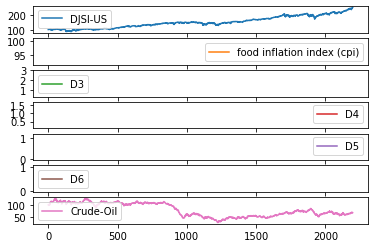

In [9]:
df.plot(subplots=True)

#### After interpolation

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

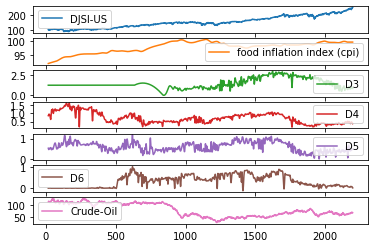

In [19]:
df.plot(subplots=True)

In [69]:
df['Date'] = pd.to_datetime(df['Date'])
#df = df.set_index('Date')
df

,DJSI-US,food inflation index (cpi),D3,D4,D5,D6,Crude-Oil
Date,,,,,,,
2011-03-01,103.32,92.110000,1.200000,0.854260,0.531345,0.010102,113.34
2011-03-03,104.83,92.127173,1.200000,0.876076,0.507671,0.010250,114.42
2011-03-04,103.99,92.144182,1.200000,0.907353,0.482661,0.010273,115.71
2011-03-07,103.20,92.161027,1.200000,0.930000,0.470000,0.010000,116.58
2011-03-08,104.00,92.177709,1.200000,0.944016,0.469689,0.009432,112.32
...,...,...,...,...,...,...,...
2019-12-24,249.38,99.680000,0.965763,0.415734,0.476455,0.071251,69.26
2019-12-26,251.86,99.680000,0.929350,0.400979,0.481941,0.058335,69.26
2019-12-27,253.88,99.680000,0.870763,0.385734,0.486455,0.041251,68.91


In [99]:
TARGET = 'DJSI-US'
y = df[TARGET]
y

Date
2011-03-01    103.32
2011-03-03    104.83
2011-03-04    103.99
2011-03-07    103.20
2011-03-08    104.00
               ...  
2019-12-24    249.38
2019-12-26    251.86
2019-12-27    253.88
2019-12-30    253.19
2019-12-31    254.12
Name: DJSI-US, Length: 2179, dtype: float64

In [92]:
# Load the data and split it into separate pieces
train_len = int(df.shape[0] * 0.9)
train_data, test_data = df[:train_len], df[train_len:]

y_train = train_data[TARGET].values
y_test = test_data[TARGET].values

print(f"{train_len} train samples")
print(f"{df.shape[0] - train_len} test samples")

1961 train samples
218 test samples


In [93]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


In [94]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6691.933, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6688.070, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6685.942, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6685.933, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6689.316, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6687.933, Time=0.64 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6687.933, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6689.933, Time=0.73 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6687.495, Time=0.17 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 3.816 seconds


In [95]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    
    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)
    
print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean squared error: 3.0608873167906854
SMAPE: 0.5803022680811587


In [90]:
preds = pd.DataFrame(forecasts, index = test_data.index)
actuals = pd.DataFrame(y_test, index = test_data.index)
res = pd.concat([actuals, preds], axis = 1)
res.columns = ['Actuals', 'Predicted']
res['Delta'] = ((res['Actuals'] - res['Predicted'])/res['Predicted']) * 100
res

,Actuals,Predicted,Delta
Date,,,
2019-02-07,208.12,209.604640,-0.708305
2019-02-08,210.05,208.241643,0.868393
2019-02-11,205.74,210.019889,-2.037850
2019-02-12,205.41,206.001144,-0.286962
2019-02-13,207.25,205.490292,0.856346
...,...,...,...
2019-12-24,249.38,250.853181,-0.587268
2019-12-26,251.86,249.514586,0.939991
2019-12-27,253.88,251.819003,0.818444


In [100]:
auto2 = pm.auto_arima(y, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7580.169, Time=6.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7584.584, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7582.121, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7582.055, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7588.068, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7585.958, Time=0.88 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7583.479, Time=3.50 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7580.464, Time=6.79 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7581.083, Time=5.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7577.461, Time=3.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7583.958, Time=0.53 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7583.973, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7588.035, Time=0.28 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 28.886 seconds


In [109]:
forecasts = auto2.predict(n_periods=15)

In [108]:
forecast_indexes = pd.date_range(start=df.index[-1], periods=16)
forecast_indexes = forecast_indexes[1:]
forecast_indexes

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
               '2020-01-13', '2020-01-14', '2020-01-15'],
              dtype='datetime64[ns]', freq='D')

In [110]:
future_forecasts = pd.DataFrame(forecasts, index = forecast_indexes)
future_forecasts

,0
2020-01-01,253.969153
2020-01-02,253.838445
2020-01-03,253.726023
2020-01-04,253.630207
2020-01-05,253.549471
2020-01-06,253.482428
2020-01-07,253.427820
2020-01-08,253.384503
2020-01-09,253.351440
2020-01-10,253.327689


In [115]:
new_preds = pd.concat([preds, future_forecasts])
new_preds.columns = ['Actuals']

final_results = pd.concat([actuals, new_preds], axis = 1)
final_results.columns = ['Actuals', 'Predicted']
final_results['Delta'] = ((final_results['Actuals'] - final_results['Predicted'])/final_results['Predicted']) * 100
final_results.tail(50)

,Actuals,Predicted,Delta
2019-11-11,241.15,241.263313,-0.046966
2019-11-13,242.23,241.219603,0.418870
2019-11-14,240.65,242.247035,-0.659259
2019-11-15,241.24,240.789961,0.186901
2019-11-18,242.95,241.282678,0.691025
2019-11-19,241.06,242.935574,-0.772046
2019-11-20,241.84,241.214794,0.259191
2019-11-21,241.33,241.873973,-0.224899
2019-11-22,242.92,241.420691,0.621036
2019-11-25,244.46,242.911420,0.637508
